# **Etude du slicing en 5G**

$\textcolor{green}{
Maël \ Le \ Guillouzic\\
Alexandre \ Mallez}
$

---

## 2. Préliminaire

**Question 1 :** Si on a S serveurs, la probabilité d'avoir exactement k $\in$ {0,1...,S} serveurs occupés est donné par la formule :
$ P_k = \frac{\frac{\rho^k}{k!}}{\sum_{j=0}^S \frac{\rho^j}{j!}} $


Mais pour éviter d'utiliser la factoriel, on utilise plutôt la relation de récurrence sans normaliser les $P_k$ pour l'instant (avec les $P'_k) :

- $ P'_0 = 1 $ 

- $ P'_k = \frac{\rho}{k} P'_{k-1} $

et $ P_k = \frac{P'_k}{\sum_{j=0}^S \frac{\rho^j}{j!}} $

De plus le nombre moyen de clients dans une file M/M/S/S à l’état stationnaire est donné par l'esperance de P :

- $ \sum_{k=0}^S kP_k = \sum_{k=0}^S \frac{kP'_k}{\sum_{j=0}^S P'_j}$

In [17]:
def mean_number_waiting_customers ( arrival_rate , service_rate , nb_of_servers ) :
    Prob=[1]
    rho=arrival_rate/service_rate
    for k in range(1,nb_of_servers+1):
        Prob.append(Prob[k-1]*rho/k)
    som=sum(Prob)
    Prob=[i/som for i in Prob] #normalization
    Esp=0
    for j in range(0,nb_of_servers+1):
        Esp+=j*Prob[j]
    return Esp

In [18]:
#Exemple :
print(f"La moyenne du nombre de clients en attente est : {mean_number_waiting_customers(40, 30, 4)} pour 4 serveurs, un taux d'arrivée de 40 et un taux de service de 30")
print(f"La moyenne du nombre de clients en attente est : {mean_number_waiting_customers(0.5, 1, 3)} pour 3 serveurs, un taux d'arrivée de 0.5 et un taux de service de 1")

La moyenne du nombre de clients en attente est : 1.2864983534577388 pour 4 serveurs, un taux d'arrivée de 40 et un taux de service de 30
La moyenne du nombre de clients en attente est : 0.49367088607594933 pour 3 serveurs, un taux d'arrivée de 0.5 et un taux de service de 1


**Question 2 :** Calcul de Erlang

In [19]:
def calculErlang(arrival_rate, service_rate, S):
    Erlang=[1]
    rho = arrival_rate / service_rate
    for k in range(1, S+1):
        Erlang.append(1/(1 + k/(rho*Erlang[-1])))
    return Erlang[-1]

print(f"Erlang B pour 4 serveurs, un taux d'arrivée de 40 et un taux de service de 30 est : {calculErlang(40, 30, 4)}")
print(f"Erlang B pour 9 serveurs, un taux d'arrivée de 5 et un taux de service de 2 est : {calculErlang(5,2,9)}")

Erlang B pour 4 serveurs, un taux d'arrivée de 40 et un taux de service de 30 est : 0.03512623490669594
Erlang B pour 9 serveurs, un taux d'arrivée de 5 et un taux de service de 2 est : 0.000863140131706887


Avec 9 serveurs, un taux d'arrivée de 5 et un taux de service de 2 on obtient un $ Erl_B[\rho,S] $ de l'ordre de $10^{-3}$ :

In [20]:
print(mean_number_waiting_customers(5, 2, 9))
print(f'rho={5/2}')

2.4978421496707326
rho=2.5


On remarque que le nombre moyen de clients calculé est très proche de $\rho$. Ce qui est cohérent, car pour ces paramètres, la probabilité de blocage est très faible, donc presque tous les clients sont acceptés.

On sait que pour le cas M/M/$\infty$, le nombre moyen de client vaut exactement la valeur de $\rho$ car aucun client n'est rejeté. Ainsi quand $Erl_B[\rho,S]≪1$ le systeme tend a se comporter comme un M/M/$\infty$ .

---

## 3. Modélisation

**Question 1 :**
Il ne peut y avoir plus de serveurs occupés que de serveurs donc 

- $ S_1 + S_2 \leq S $ (1)

Comme les client de type 1 ne peuvent pas être mis en attente, on a aussi :

- $ Q_1 = S_1 $  (2)

Les client de type 2  dans le système sont : soit dans le buffer, soit occupe un serveur donc : 

- $ Q_2 = S_2 + B $  

- $ Q_2 \leq S_2 $ 


En combinant (1) et (2) on a déjà : $q_1 + s_2 \leq S $

De plus le cas d'inégalité stric signifie qu'il reste des serveur innocupé ($ n = S - s_2 - s_1 > 0$), et dans ce cas il ne peut y avoir de client dans le buffer (auquel cas ils auraient quitté le buffer et iraient occuper un serveur libre).

Ainsi l'inégalité strict $q_1 + s_2 < S $ ne se produit que si b=0.

**Question 2 :** Etant donné la priorité des clients de type 1 sur ceux de type 2 (un client de type 1 qui arrive prend la place d'un type 2 si aucun autre serveur n'est disponible), c'est comme s'il n'y avait pas de type 2 (les clients de types 2 n'ont aucun impact sur ceux de types 1) . De plus si tout les serveurs sont occupés par des types 1, le client est refusé.

Ainsi la dynamique du processus Q1 ne dépend que de l'état actuel (et non du passé) ce qui en fait un processus de Markov. De plus les arrivées de clients type 1 forment un processus de Poisson et les durées de service sont exponentielles donc on reconnait bien une dynamique de file M/M/S/S (de paramètres $\lambda_1 ,\mu_1$ et S  ).

**Question 3 :**
$Q_1 \in {0,1,...,S}$ et $Q_2 \in \N $ car il y a une place infini dans le buffer B .

- à l'arrivé d'un client de type 1 : 

    $(q_1,q_2) -> (q_1 + 1 , q_2)$ si $ q_1 < S $ (soit il y a un serveur libre, soit un client de type 2 va être décalé dans un buffer ce qui n'influence pas $q_2$)

    $(q_1,q_2) -> (q_1,q_2)$ si $ q_1 = S $ (le client est rejeté)

    avec un taux $\lambda_1$ (car arrivées selon un processus de Poisson)

- au départ d'un client de type 1 :

    $(q_1,q_2) -> (q_1 - 1 , q_2)$ avec un taux $s_1\mu_1 = q_1\mu_1$ car il y a $s_1 = q_1$ client de type 1 actif dans les serveurs.

- à l'arrivé d'un client de type 2 :

    $(q_1,q_2) -> (q_1 , q_2 + 1)$ (dans tous les cas le client va dans le buffer même si aucun serveur n'est disponible)

    avec un taux $\lambda_2$ (car arrivées selon un processus de Poisson)

- au départ d'un client de type 2 : 

    $(q_1,q_2) -> (q_1,q_2 - 1)$ avec un taux $s_2\mu_2$ car il ya $s_2$ client de type 2 actif dans les serveurs

    Or on a d'après Q1) $s_2\leq q_2$ et  $s_2 \leq S - q_1$ avec égalité $s_2 = S - q_1$ si $b\neq 0$ et sinon on a $s_2 = q_2$ si $b=0$

    Donc on a $s_2\leq min(q_2,S - q_1)$ or on a soit $s_2 = q_2$ soit $s_2 = S - q_1$

    On en conclu donc que $s_2 = min(q_2,S - q_1)$ et donc le taux de la transition $(q_1,q_2) -> (q_1,q_2 - 1)$ vaut $min(q_2,S - q_1)\mu_2$.

Les transitions possibles sont donc : 

-$(q_1,q_2) -> (q_1 + 1 , q_2)$

-$(q_1,q_2) -> (q_1 - 1 , q_2)$ 

-$(q_1,q_2) -> (q_1 , q_2 + 1)$

-$(q_1,q_2) -> (q_1,q_2 - 1)$

et ce dernier à un taux de transition donné par  $min(q_2,S - q_1)\mu_2$




**Question 4 :**

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def file_priorite(arrival_rate1, service_rate1, arrival_rate2, service_rate2, S, temps_secondes=1000,Aff=True ):
    
    
    x1 = [0]
    x2 = [0]
    buffers = [0] # pour suivre le nombre de clients de type 2 dans le buffer
    s2s = [0] # pour suivre le nombre de clients de type 2 en service

    buffer=0 # clients type 2 en attente
    q1= 0 # nombre de clients type 1 en service
    q2= 0 # total clients type 2 (service + buffer)
    s2= 0 # clients type 2 en service

    #On prend un pas de temps delta_t=0.01s
    dt = 0.01 
    nb_iterations=int(temps_secondes/dt)

    #On utilise les taux calculé Q3)
    for i in range(nb_iterations):
        
        if np.random.random() < arrival_rate1*dt: #arrivé d'un client de type 1
            if q1 < S:
                if s2 + q1 == S:
                    buffer+=1
                    s2-=1
                q1+=1

        if np.random.random() < arrival_rate2*dt: #arrivé d'un client de type 2
            if s2 + q1 < S:
                s2+=1
            else:
                buffer+=1
            q2+=1
        
        for _ in range(q1): # on parcourt les clients de type 1 en service
            if np.random.random() < service_rate1*dt: # départ du client de type 1
                q1-=1
                if buffer > 0:
                    buffer-=1
                    s2+=1
        
        # Avec ce qu'on a calulé Q3), on peut calculé le taux
        n_serving_2 = min(q2, S - q1)
        actual_serving_2 = min(s2, n_serving_2)
        departures2 = 0
        for _ in range(actual_serving_2):
            if np.random.rand() < service_rate2 * dt:
                q2 -=1
                s2 -=1

        while buffer > 0 and q1 + s2< S: #on transfert le client de type 2 dans le buffer vers le service
            buffer -= 1
            s2 += 1

        if s2 + q1 > S:
            print('WTF')
        
        x1.append(q1)
        x2.append(q2)
        buffers.append(buffer)
        s2s.append(s2)

    time = np.arange(nb_iterations+1) * dt
    if Aff:
        plt.figure(figsize=(10, 6))
        plt.plot(time, x1, label="x1(t) = clients type 1 en service")
        plt.plot(time, x2, label="x2(t) = clients type 2 (total)")
        #plt.plot(time, buffers, label="clients type 2 dans le buffer")
        #plt.plot(time, s2s, label="clients type 2 en service")
        plt.xlabel("Temps")
        plt.ylabel("Nombre de clients")
        plt.title("Simulation en temps discret")
        plt.legend()
        plt.grid()
        plt.show()
    return x1, x2


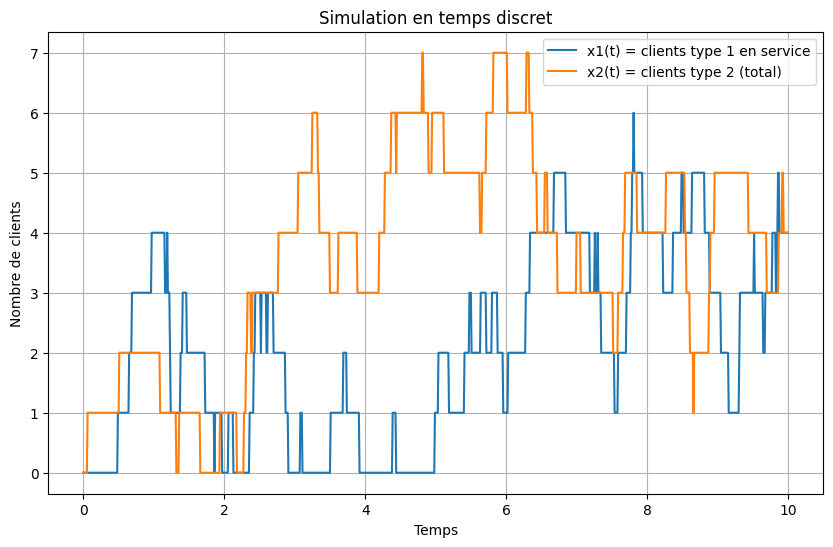

In [23]:
x1,x2=file_priorite(4, 2, 3, 1, 10, 10)

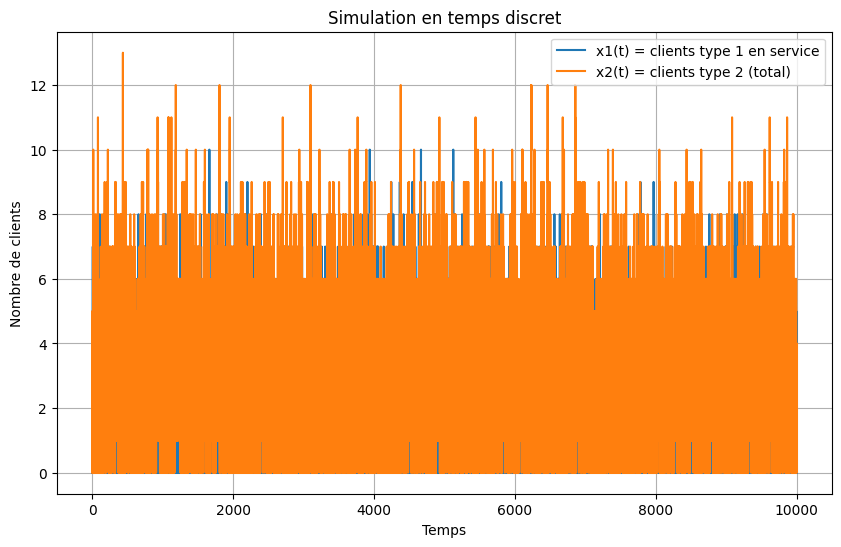

integral=2.6999973000027e-05


In [24]:
x1,x2=file_priorite(4, 2, 3, 1, 10, 10000, Aff=True)
tot=0
for x in x1:
        if x==10:
            tot+=1
integral=tot/len(x1)
print(f"integral={integral}")

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


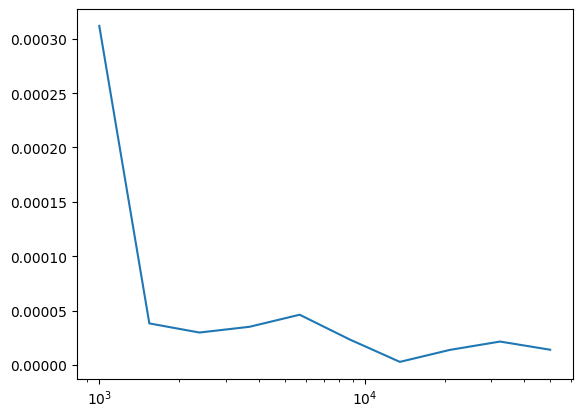

In [25]:
from tqdm import tqdm as tqdm
T=np.geomspace(1000,50000,num=10,dtype=int) # temps d'attente pour le client de type 2
S=10 # nombre de serveurs dans notre cas

comparaison=[]
Erlang=calculErlang(4, 2, S)
for t in tqdm(T):
    x1,x2=file_priorite(4, 2, 3, 1, S, t, Aff=False)
    tot=0
    for x in x1:
        if x==S:
            tot+=1
    integral=tot/len(x1)
    comparaison.append(np.abs(Erlang - integral))
plt.plot(T, comparaison, label="Erreur entre la simulation et Erlang")
plt.xscale('log')
plt.show()

In [26]:
print("Valeur de Erlang :", Erlang)

Valeur de Erlang : 3.819016794126352e-05


Avec nos paramètres, comme Erlang est très petit il faut un temps très grand avant d'aboutir à un résultat cohérent (ce qui n'est pas le cas ici) ce qui complique la comparaison, essayons avec des meilleurs paramètres : 

In [27]:
lambda1=3
mu1=1
S=5
new_Erlang=calculErlang(3, 1, 5)
print(new_Erlang)

0.11005434782608692


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


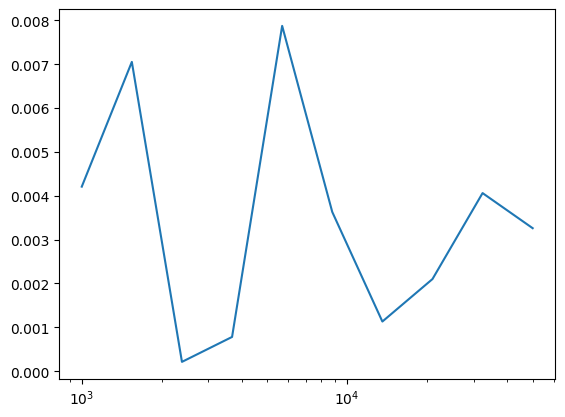

In [28]:
T=np.geomspace(1000,50000,num=10,dtype=int) # temps d'attente pour le client de type 2
comparaison=[]
for t in tqdm(T):
    x1,x2=file_priorite(lambda1, mu1, 2, 1, S, t, Aff=False)
    tot=0
    for x in x1:
        if x==S:
            tot+=1
    integral=tot/len(x1)
    comparaison.append(np.abs(new_Erlang - integral))
plt.plot(T, comparaison, label="Erreur entre la simulation et Erlang")
plt.xscale('log')
plt.show()

Théoriquement : 

Cette intégrale représente le temps moyen passé sur l'espace de temps [0,T] dans l'état où $Q_1 = S$, c'est à dire où tous les serveurs sont occupés par des clients de type 1.

Lorsque T tend vers $\infty$ cela correspond exactement à la probabilité de blocage $Erl_B[\rho_1,S]$ avec $\rho_1 = \frac{\lambda_1}{\mu1}$ dont la formule constitue le terme de droite.

---

## 4. Stationnarité 

Le papier 1 nous fournit une condition pour que le système admette une loi stationnaire. C'est le cas ssi :
$$
\rho_2 \;+\; \frac{\displaystyle\sum_{k=0}^{S} k\,\rho_{1}^{k}/k!}
                 {\displaystyle\sum_{j=0}^{S} \rho_{1}^{j}/j!}
\; <\; S
$$
Essayons de simuler ce resultat.

In [36]:
def simulation(lambda1,mu1,lambda2,mu2,S,T=1000,dt=0.0001):
    q1, q2, buf2, s2 = 0, 0, 0, 0
    x1_hist, x2_hist = [], []
    pas = int(T/dt)
    for i in tqdm(range(pas)):
        # arrivée d'un client de type-1 (pas plus de S clients en service)
        if np.random.random() < lambda1 * dt:
            if q1 < S: # au moins un slot libre
                if s2 + q1 == S: # complet mais un client de type-2 dans le buffer
                    buf2 += 1 
                    s2 -= 1
                q1 += 1
        # arrivée d'un client de type-2
        if np.random.random() < lambda2 * dt:
            if s2 + q1 < S:
                s2 += 1
            else:
                buf2 += 1
            q2 += 1
        # depart d'un client de type-1
        for j in range(q1):
            if np.random.random() < mu1 * dt:
                q1 -= 1
                if buf2: # repêche dans le buffer
                    buf2 -= 1
                    s2 += 1
        # depart d'un client de type-2 (min(q2, S-q1) en service)
        active2 = min(q2, S - q1, s2)
        for j in range(active2):
            if np.random.random() < mu2 * dt:
                q2 -= 1
                s2 -= 1
        # transfert du buffer vers le service
        while buf2 and (q1 + s2) < S:
            buf2 -= 1;  s2 += 1
        x1_hist.append(q1) # on stocke sous forme de liste comme ca on pourra tracer les courbes
        x2_hist.append(q2)
    return np.array(x1_hist), np.array(x2_hist)

Simulons quelques situations.

In [37]:
# Calcul de la partie gauche de l'inégalité (2)
S = 10
lambda1 = 4
mu1 = 2
lambda2 = 3
mu2 = 1
rho1, rho2 = lambda1/mu1, lambda2/mu2

nb_clients_att = mean_number_waiting_customers(lambda1, mu1, S)
Termegauche = rho2 + nb_clients_att

print(f"Rho1 = {rho1:.2f}, Rho2 = {rho2:.2f}")
print(f"E[N1]={nb_clients_att:.4f}")
print(f"Termegauche={Termegauche:.4f}")
print(f"Est il inférieur à S (sachant que S={S}) ? {Termegauche < S}")


Rho1 = 2.00, Rho2 = 3.00
E[N1]=1.9999
Termegauche=4.9999
Est il inférieur à S (sachant que S=10) ? True


In [38]:
x1_stable,x2_stable = simulation(lambda1, mu1, lambda2, mu2, S)
q1_moy, q2_moy = x1_stable.mean(), x2_stable.mean()

print(f"Simulation : q1_moy = {q1_moy:.3f}, q2_moy = {q2_moy:.3f}")
print(f"Somme des 2 : {q1_moy + q2_moy:.3f}")
print(f"Est il inférieur à S (sachant que S={S}) ? {q1_moy + q2_moy < S}")


100%|██████████| 10000000/10000000 [00:14<00:00, 670963.52it/s]


Simulation : q1_moy = 1.912, q2_moy = 3.046
Somme des 2 : 4.958
Est il inférieur à S (sachant que S=10) ? True


Cherchons désormais un cas de figure ou ce n'est pas stable.

In [39]:
# cas de figure ou ce n'est pas stable
lambda1, mu1, lambda2, mu2 = 4, 2, 8, 1
S = 10
x1_instable, x2_instable = simulation(lambda1, mu1, lambda2, mu2, S)

print(f"Simulation : q1_moy = {x1_instable.mean():.3f}, q2_moy = {x2_instable.mean():.3f}")
print(f"Somme des 2 : {x1_instable.mean() + x2_instable.mean():.3f}")
print(f"Est il inférieur à S (sachant que S={S}) ? {x1_instable.mean() + x2_instable.mean() < S}")

100%|██████████| 10000000/10000000 [00:23<00:00, 428641.07it/s]


Simulation : q1_moy = 2.051, q2_moy = 109.541
Somme des 2 : 111.592
Est il inférieur à S (sachant que S=10) ? False


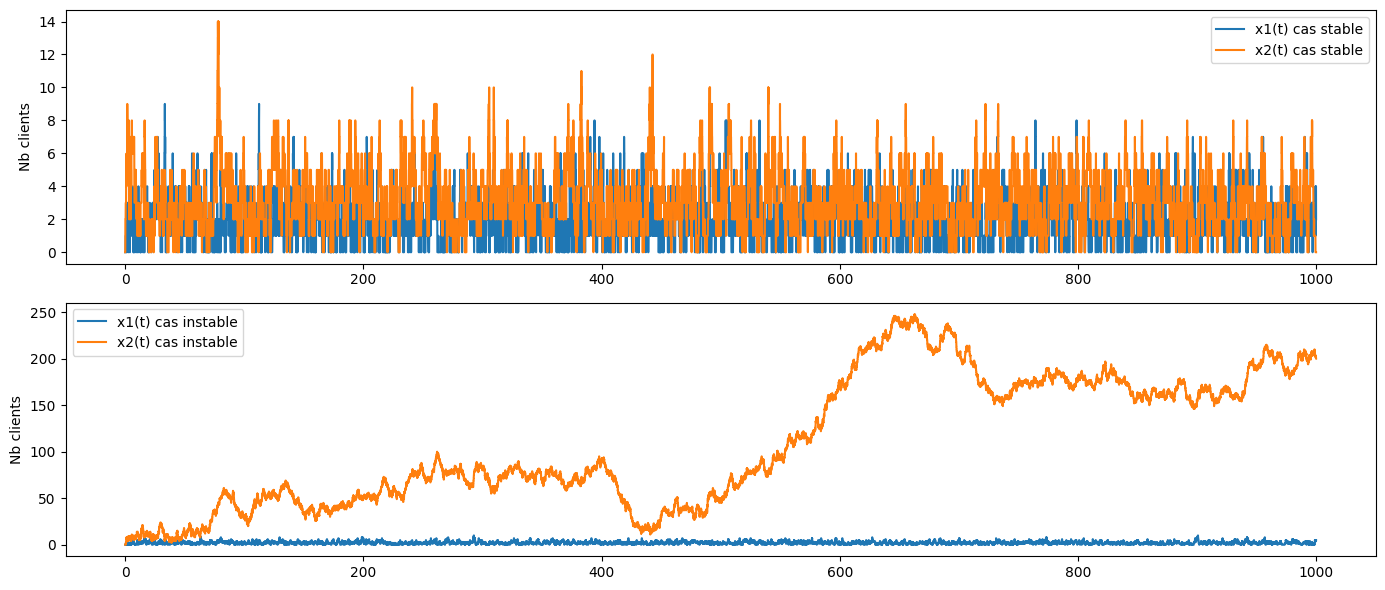

In [67]:
# Tracons les 2 courbes stable et instable sur 2 graphes distincts
T = np.linspace(0,1000,10000*1000)
plt.figure(figsize=(14,6))
plt.subplot(2, 1, 1)
plt.plot(T, x1_stable[:10000*1000], label="x1(t) cas stable")
plt.plot(T, x2_stable[:10000*1000], label="x2(t) cas stable")
plt.ylabel("Nb clients")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(T, x1_instable[:10000*1000], label="x1(t) cas instable")
plt.plot(T, x2_instable[:10000*1000], label="x2(t) cas instable")
plt.ylabel("Nb clients")
plt.legend()
plt.tight_layout()
plt.show()

**Question :** Peut-on déduire la condition (2) à partir de la simulation ?

A priori, **Oui** la simulation suffit à repérer s’il y a stationnarité ou non. Néanmoins elle ne nous dit pas comment sont partagés les serveurs.
En d'autres termes, la simulation confirme la frontière mais ne nous permet pas de la chiffrer précisemment.

---

## 5. Calcul de la probabilité stationnaire

**Question 1 :**

Au-delà du rang $S$ le générateur par blocs est stationnaire : les trois blocs de la bande diagonale valent donc toujours  
$$
\;A_S,\; B_S,\; \lambda_2\,\mathrm{Id}\;
$$ 
Les équations d’équilibre se lisent donc, pour tout $j\ge S$,
$$
x_{j-1}\,\lambda_2 \mathrm{Id}\;+\;x_j\,B_S\;+\;x_{j+1}\,A_S \;=\;0.
\tag{E}
$$

On pose $ x_j = x_S R^{j-S}$ où $j\ge S$ et oû $R$ est la matrice définie dans le sujet par l’équation  
$$
\lambda_2 \mathrm{Id}\;+\;R\,B_S\;+\;R^{2}A_S=0  \tag{3}
$$

Remplacons les $x_j$ dans (E) :

$$
\begin{aligned}
x_{j-1}\lambda_2\mathrm{Id}&=x_S R^{\,j-S-1}\lambda_2\mathrm{Id},\\
x_j B_S&=x_S R^{\,j-S}B_S,\\
x_{j+1}A_S&=x_S R^{\,j-S+1}A_S.
\end{aligned}
$$

Et ainsi en factorisant $x_S R^{\,j-S-1}$ :
$$
x_S R^{j-S-1} [\lambda_2 Id + R B_S + R^2 A_S ] = 0
$$
Le crochet est nul grace à l'équation (3).

Et ainsi on a bien $ x_j = x_S R^{j-S}$ solution des équations d’équilibre au dela du rang S.

**Question 2 :**

A l'indice $j = S$ le générateur n’est plus stationnaire :  
il combine  
* $(\lambda_2\mathrm{Id}, A_S)$ identique a ce qu'on avait avant
* un bloc central $B_S = M - A_S - \lambda_2\mathrm{Id}$

Et donc en $j=S$
$$
x_{S-1} \lambda_2 Id  +  x_S B_S  +  x_{S+1} A_S  = 0.        \tag{4}
$$

Or, d’après $Q1$, on sait que $x_{S+1}=x_S R$

On divise (4) par $\lambda_2$ et on utilise $\widetilde{A}_{S} = \frac{1}{\lambda_{2}} A_{S} \ \text{et} \ \widetilde{B}_{S} = \frac{1}{\lambda_{2}} B_{S}$

On a ainsi :
$$
x_{S-1} + x_S \widetilde{B}_{S} + x_S R \widetilde{A}_{S} = 0
$$

Ce qui est exactement demandé par la question !

**Question 3 :**

On veut construire une suite de matrices $T_{j}$ telles que pour tout $j$ on ait
$$
x_{j+1} \;=\; x_{j}\,T_{j}
$$


Pour tout $0\le j\le S-1$ on peut procéder de la même manière qu'a la question précédente, et diviser l'équation fournie par le générateur par $\lambda_{2}$ et utiliser les relations sur $\widetilde{A}_{j}$ et $\widetilde{B}_{j}$ pour aboutir à :
$$
x_{j-1} + x_{j}\widetilde B_{j} + x_{j+1} \widetilde A_{j+1} = 0 \tag{5}
$$


En utilisant le résultat de la question précédente $ x_{S-1} \;=\; -\,x_{S}\,\bigl(\widetilde B_{S} + R\,\widetilde A_{S}\bigr) $,

on pose 
$$
T_{S-1} = -\bigl(\widetilde B_{S} + R \widetilde A_{S}\bigr)^{-1}
\tag{6}$$
et on a bien $ x_{S} = x_{S-1} T_{S-1}$. Montrons désormais cela par récurrence.

*Initialisation : OK*

*Hérédité : Soit $j\le S-2$, supposons qu'on a la relation $x_{j+1}=x_{j}\,T_{j}$. Alors en injectant dans (5)*

$$
x_{j-1} + x_{j} \widetilde B_{j} + x_{j} T_{j} \widetilde A_{j+1}=0
$$
i.e.
$$
x_{j-1} = - \ x_{j}\bigl(\widetilde B_{j} + T_{j}\widetilde A_{j+1}\bigr)
$$

et donc en posant $ T_{j-1} = -\bigl(\widetilde B_{j} + T_{j}\widetilde A_{j+1}\bigr)^{-1} $ on a bien une expression de $x_{j}$ en fonction de $x_{j-1}$

A l'aide de l'égalité 6 et de la relation de récurrence entre les $T_j$ et $T_{j-1}$, on peut obtenir une expression explicit de tout les $T_j$.

On a ainsi le résultat demandé.



**Question 4 :**

Dans la matrice génératrice en utilisant la colonne $j = 0$ qui ne possède que $M-\lambda_2 I$ sur la ligne $j$ et le bloc $A_1$ sur la ligne $j+1$ (qui décrit un retour du niveau 1 vers 0), on a :
$$
x_1 A_1 + x_0 (M-\lambda_2 I) = 0.
\tag{E0}
$$

En utilisant la question précédente, 
$$
x_0 T_0 A_1 + x_0 (M-\lambda_2 I)=0.
$$

D'ou la relation demandée.

**Question 5 :**

L’équation de la question précédente se ré-écrit  
$$
x_S \ (T_0^{-1}T_1^{-1}\dots T_{S-1}^{-1}) \ K = 0
$$  
avec $K = (M-\lambda_2 I)+T_0A_1$.

La matrice $(T_0^{-1}T_1^{-1}\dots T_{S-1}^{-1})$ est évidemment inversible et donc $Ker((T_0^{-1}T_1^{-1}\dots T_{S-1}^{-1}) \ K) = Ker(K)$

Or $Ker(K)$ est de dimension 1. En trouvant donc un vecteur non nul de cet ensemble on a la direction de $x_S$.

De plus, la norme 1 de $x_S$ vaut 1 par définition de la probabilité $\pi$ (et que $\pi_{(k,S)} = 0 \forall k > S $).

Par sa direction et sa norme on peut donc déterminer $x_S$ .

**Question 6 :** On veut retrouver la figure 2 du papier fourni, dont on met un screen ci dessous.

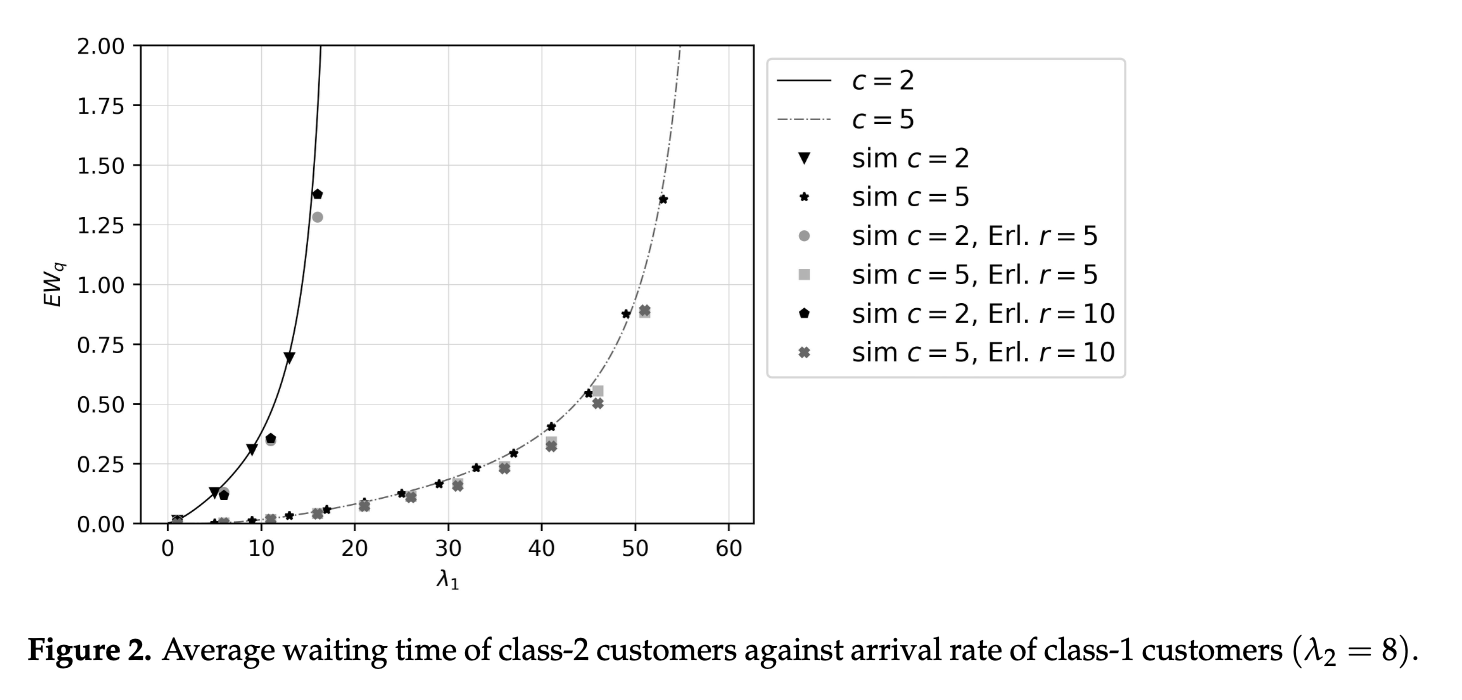

On utilise les paramètres suivants :
  - nombre total de serveurs : $S = 5$  
  - $\lambda_2 = 8$ et $\mu_2 =20$
  - on va faire varier $\lambda_1$ de 0 à 60 et on fixera $\mu_1 = 4$   

Pour chaque $\lambda_1$ on simule, on enregistre **le temps d’attente** de chaque client et on fait la moyenne. 

Il nous faut modifier un tout petit peu notre fonction `simulation()`.

In [ ]:
def simulation_2(lambda1,mu1,lambda2,mu2,S,T=1000,dt=0.001):
    q1, q2, buf2, s2 = 0, 0, 0, 0
    buf_t = [] 
    wait_1 = wait_2 = 0.0
    pas = int(T/dt)
    for i in tqdm(range(pas)):
        t = i*dt
        # arrivée d'un client de type-1 (pas plus de S clients en service)
        if np.random.random() < lambda1 * dt:
            if q1 < S: # au moins un slot libre
                if s2 + q1 == S: # complet mais un client de type-2 dans le buffer
                    buf2 += 1 
                    s2 -= 1
                    buf_t.append(t)
                q1 += 1
        # arrivée d'un client de type-2
        if np.random.random() < lambda2 * dt:
            if s2 + q1 < S:
                s2 += 1
            else:
                buf2 += 1
                buf_t.append(t)
            q2 += 1
        # depart d'un client de type-1
        for j in range(q1):
            if np.random.random() < mu1 * dt:
                q1 -= 1
                if buf2: # repêche dans le buffer
                    buf2 -= 1
                    s2 += 1
                    t0 = buf_t.pop(0)
                    wait_1 += t - t0
                    wait_2 += 1
        # depart d'un client de type-2 (min(q2, S-q1) en service)
        active2 = min(q2, S - q1, s2)
        for j in range(active2):
            if np.random.random() < mu2 * dt:
                q2 -= 1
                s2 -= 1
        # transfert du buffer vers le service
        while buf2 and (q1+s2) < S:
            buf2 -= 1;  s2 += 1
            t0 = buf_t.pop(0)
            wait_1 += t - t0
            wait_2 += 1
    return wait_1/max(wait_2,1)


Si le temps d'execution est trop long on pourra diminuer le temps de calcul ou le pas.

In [57]:
S = 5
mu1, mu2 = 4,20
lambda2  = 8.0
l1_vals  = np.arange(0, 65, 5)
Ew_vals  = [simulation_2(l1, mu1, lambda2, mu2, S,T=10000,dt=0.001) for l1 in l1_vals]

100%|██████████| 10000000/10000000 [00:19<00:00, 500309.84it/s]


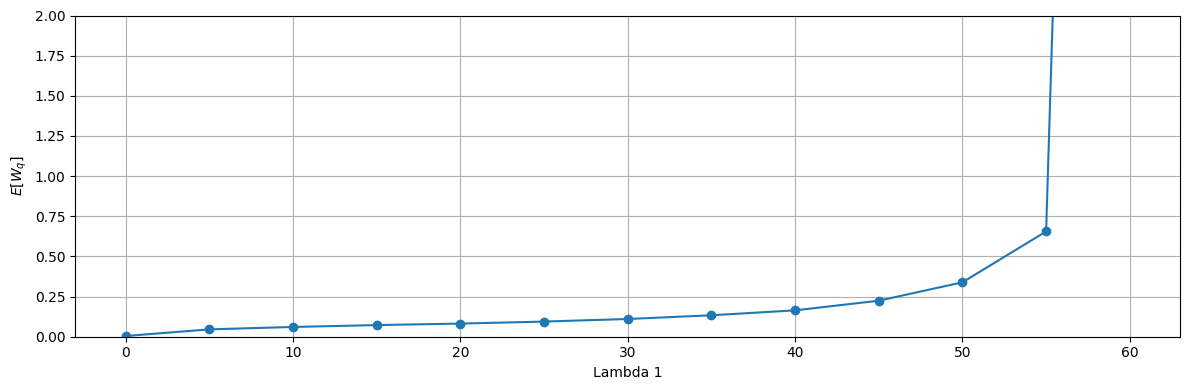

In [66]:

plt.figure(figsize=(12,4))
plt.plot(l1_vals, Ew_vals, marker="o")
plt.xlabel("Lambda 1")
plt.ylabel(r"$E[W_q]$")
plt.yticks(np.arange(0,2.25,0.25))
plt.ylim(0,2)
plt.tight_layout()
plt.grid()
plt.show()

On obtient une courbe avec une allure similaire à la figure 2, et avec des valeurs cohérentes.

---

## 6. Canaux de garde

**Question 1 :** Pourquoi $(Q_1,Q_2)$ n’est-plus Markov ?  

Avec la règle « un client classe 2 ne peut entrer que s’il reste au moins G serveurs libres », il faut savoir combien de clients classe 2 sont déjà en service afin de compter le nombre de libres $L=S-Q_1-S_2$  

Or $Q_2 = S_2 + B$ (service + buffer).  
Connaître seulement $(Q_1,Q_2)$ ne permet pas de séparer $S_2$ et B, ainsi la dynamique du processus dépend du passé (la connaissance du nombre de serveur libre) ce qui implique que le processus n’est plus markovien.

**Question 2:** 

Pour représenter la dynamique du système avec un processus de Markov il faut donc rajouter une nouvelle variable qui permettrait de savoir combien de serveur est libre. On peut représenter par : $(Q_1,S_2,B)$.

Ces trois variabless permettent de compenser le problème qui faisait que $(Q_1,Q_2)$ n'était plus Markovien, en effet on a maintenant la connaissance du nombre de serveur libre $(S-Q_1-S_2)$ et donc la dynamique ne dépend plus du passé. Ainsi $(Q_1,S_2,B)$ est Markovien.

- à l'arrivé d'un client de type 1 : 

    $(q_1,s_2,b) -> (q_1 + 1 , s_2,b)$ si $ q_1+s_2 < S $ (le client est accepté car il y a de la place)

    $(q_1,s_2,b) -> (q_1, s_2, b)$ si $ q_1 + s_2 = S $ (le client est rejeté)

    les deux avec un taux $\lambda_1$ (car arrivées selon un processus de Poisson)

- au départ d'un client de type 1 :

    $(q_1,s_2,b) -> (q_1 - 1 , s_2 , b)$ si $ q_1+s_2  > S - G$ ou si $b=0 $

    $(q_1,s_2,b) -> (q_1 - 1 , s_2 + 1 , b - 1)$ si $ q_1+s_2  \leq S - G $ et si $b\neq 0$ (un client de type 2 du buffer prend la place libéré par celui de type 1 (s'il y a assez de marge G))
    
    avec un taux $s_1\mu_1 = q_1\mu_1$ car il y a $s_1 = q_1$ client de type 1 actif dans les serveurs.

- à l'arrivé d'un client de type 2 :

    $(q_1,s_2,b) -> (q_1,s_2,b+1)$ si $ q_1+s_2 > S - G$ (le client est mis en attente car le nombre de serveur disponible est inférieur à G)

    $(q_1,s_2,b) -> (q_1,s_2 + 1,b)$ si $ q_1+s_2 \leq S - G $

    avec un taux $\lambda_2$ (car arrivées selon un processus de Poisson)

- au départ d'un client de type 2 : 

    $(q_1,s_2,b) -> (q_1,s_2-1,b)$ si $b=0$ ou si $ q_1+s_2 > S - G$

    $(q_1,s_2,b) -> (q_1,s_2,b-1)$ si $b\neq0$  et si $q_1+s_2 \leq S - G $

    avec un taux $s_2 \mu_2$ ar il y a $s_2$ client de type 2 actif dans les serveurs.





**Question 3 :**

Dans le premier modèle de ce projet, les clients de type 2 pouvaient occuper jusqu’à $S-Q_1$ serveurs. Avec G canaux de garde ils n’en reçoivent que $S-Q_1-G$ au maximum.

La capacité “offerte” à la classe 2 est plus petite sans non plus augmenter celle de la classe 1 donc la charge admissible $\rho_2$ doit être plus basse. Autrement dit, la nouvelle condition est **plus contraignante** que celle du premier modèle.  
